# Authorship Analysis

- This is a  slight modification of authorship.ipynb but made to work with csvs. The biggest added feature is in the ability of choosing how many chapters (or other similar break in text) will be used to form the text. This is done by specifiying amount of chapters at the beggining and end. As well other smaller parts of the notebook where changed to fix errors.

This Jupyter notebook uses statistical methods to analyze the authorship of a text. The text is split into words, and the frequency of each word is calculated. The frequency of each word is then compared to the frequency of the same word in a training set of texts of known authorship. The authorship of the text is then predicted based on the similarity of the word frequencies.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import nltk
from multiprocess import Pool

import os
import sys
from typing import List, Tuple, Dict, Callable, Union, Any, Optional, Self, Set
import csv
from pathlib import Path


# Tokenization

The first step in the analysis is to tokenize the text. Tokenization is the process of splitting the text into words. The text is split into words using the `nltk` library.

# Frequency Analysis

The next step is to calculate the frequency of each word in the text. The frequency of each word is calculated by counting the number of times the word appears in the text and dividing by the total number of words in the text.

In [2]:

def tokenize(text: str) -> List[str]:
    '''
    Takes a string and returns a list of words.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
    
    Returns
    -------
    List[str]
        A list of words.
    '''
    # Split on whitespace and punctuation
    text = text.lower()
    
    # Split on punctuation
    for p in '!"#$%()*+,-./:;<=>?@[\\]^_`{|}~':
        text = text.replace(p, ' ' + p + ' ')
    
    return text.split()

def tokens_to_sentences(tokens: List[str]) -> List[str]:
    '''
    Takes a list of tokens and returns a list of sentences.
    
    Parameters
    ----------
    tokens : List[str]
        The tokens to be converted to sentences.
        
    Returns
    -------
    List[str]
        A list of sentences.
    '''
    sentences = []
    sentence = []
    for token in tokens:
        sentence.append(token)
        if token in '.!?':
            sentences.append(' '.join(sentence))
            sentence = []
    return sentences

def word_count(text: str) -> int:
    '''
    Takes a string and returns the number of words in it.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    int
        The number of words in the text.
    '''
    return len(tokenize(text))

def avg_word_length(text: str) -> float:
    '''
    Takes a string and returns the average length of the words in it.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    float
        The average length of the words in the text.
    '''
    words = tokenize(text)
    return sum(len(word) for word in words) / len(words)

def unique_words(text: str) -> int:
    '''
    Takes a string and returns the number of unique words in it.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    int
        The number of unique words in the text.
    '''
    return len(set(tokenize(text)))

def avg_sentence_length(text: str) -> float:
    '''
    Takes a string and returns the average length of the sentences in it.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    float
        The average length of the sentences in the text.
    '''
    sentences = tokens_to_sentences(tokenize(text))
    if len(sentences) == 0:
        return 0  # Return 0 or another default value when no sentences are found
    return sum(len(sentence) for sentence in sentences) / len(sentences)

def word_count_map(text: str) -> Dict[str, int]:
    '''
    Takes a string and returns a dictionary of words and their counts.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    Dict[str, int]
        A dictionary of words and their counts.
    '''
    return {word: text.count(word) for word in tokenize(text)}

def word_freq(text: str) -> Dict[str, float]:
    '''
    Takes a string and returns a dictionary of words and their frequencies.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    Dict[str, float]
        A dictionary of words and their frequencies.
    '''
    # wc = word_count(text)
    # return {word: count / wc for word, count in word_count_map(text).items()}
    
    # Do it in parallel with multiprocessing
    # Split up the text into chunks for each process
    # Send each chunk to a different process
    # Combine the results
    
    def partition_text(text: str, partitions: int=16) -> list[str]:
        length = len(text)
        chunk_size = length // partitions
        return [text[i:i+chunk_size] for i in range(0, length, chunk_size)]
        
    text_partitions = partition_text(text)
    with Pool(16) as pool:
        results = pool.map(word_count_map, text_partitions)
    
    # Combine the results
    combined = {}
    for result in results:
        for word, count in result.items():
            combined[word] = combined.get(word, 0) + count
    
    wc = sum(combined.values())
    return {word: count / wc for word, count in combined.items()}


# Corpus

This implements an abstraction for managing a corpus of texts. The corpus is a collection of texts, each of which has an author and a title. The corpus can be used to train a model to predict the authorship of a text.

- Slight modifications made so it will work with csv instead of txt files

In [3]:
class Corpus:
    '''
    A class to represent a corpus of text data.
    
    This provides abstractions for managing text data, including:
    - reading data from files
    - managing multiple works with separate metadata
    '''
    
    def __init__(self, name: str, beginning_chapters: int, end_chapters: int):
        '''
        Initialize a new Corpus object with the number of beginning and end chapters.
        
        Parameters
        ----------
        name : str
            The name of the corpus.
        beginning_chapters : int
            The number of chapters to take from the beginning of each work.
        end_chapters : int
            The number of chapters to take from the end of each work.
        '''
        self.works = []
        self.name = name
        self.beginning_chapters = beginning_chapters
        self.end_chapters = end_chapters
    
    def add_paths(self, paths: List[str], author: str, **metadata):
        '''
        Add multiple works to the corpus from CSV files.
        
        Parameters
        ----------
        paths : List[str]
            A list of file paths to read texts from.
        author : str
            The author of the works.
        metadata : dict
            Additional metadata about the works.
        '''
        for path in paths:
            self.add_csv(path, author, **metadata)

    
    def add_csv(self, file: str, author: str, **metadata):
        '''
        Add a work to the corpus from a CSV file, selecting the specified number of
        chapters from the beginning and end.

        Parameters
        ----------
        file : str
            The path to the CSV file being processed.
        author : str
            The author of the work.
        metadata : dict
            Additional metadata about the work.
        '''
        print(f"Processing file: {file}")
        
        chapters = []
        with open(file, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            
            # Check that the CSV has the correct headers
            if 'Chapter' not in reader.fieldnames or 'Content' not in reader.fieldnames:
                raise ValueError(f"CSV file {file} must contain 'Chapter' and 'Content' headers")
            
            # Read each row of the CSV as a chapter
            for row in reader:
                chapters.append({'Chapter': row['Chapter'], 'Content': row['Content']})
        
        # Get the title from the file name (e.g., remove .csv and format the name)
        title = Path(file).stem.replace('_', ' ').title()

        total_chapters = len(chapters)
        # print(f"Total chapters in file: {total_chapters}")
        
        # Handle cases where the number of beginning + end chapters exceeds total chapters
        if self.beginning_chapters + self.end_chapters >= total_chapters:
            selected_chapters = chapters  # Add all chapters if we exceed the total
            print(f"Warning: {file} has only {total_chapters} chapters, selecting all chapters.")
        else:
            # Select the specified number of beginning and end chapters
            start_selection = chapters[:self.beginning_chapters]
            end_selection = chapters[-self.end_chapters:]
            selected_chapters = start_selection + end_selection
        
        # Print the number of characters in each selected chapter
        for i, chapter in enumerate(selected_chapters):
            chapter_length = len(chapter['Content'])
            # print(f"Adding Chapter {chapter['Chapter']} with {chapter_length} characters.")

        # Concatenate all selected chapters' content into a single text
        full_text = '\n\n'.join(ch['Content'] for ch in selected_chapters)

        # Add the work to the corpus
        self.add_work(title, author, full_text, **metadata)


    def add_work(self, title: str, author: str, text: str, **metadata):
        '''
        Add a new work to the corpus.
        
        Parameters
        ----------
        title : str
            The title of the work.
        author : str
            The author of the work.
        text : str
            The text of the work.
        metadata : dict
            Additional metadata about the work, such as publication date, genre, etc.
        '''
        self.works.append({'title': title, 'author': author, 'text': text, **metadata})

    @classmethod
    def from_paths(cls, name: str, paths: List[str], author: str, beginning_chapters: int = 1, end_chapters: int = 1, **metadata):
        '''
        Create a new corpus from a set of CSV file paths, selecting chapters from the beginning and end.
        
        Parameters
        ----------
        name : str
            The name of the corpus.
        paths : List[str]
            A list of file paths to read texts from.
        author : str
            The author of the works.
        beginning_chapters : int
            The number of chapters to take from the beginning of each work (default is 1).
        end_chapters : int
            The number of chapters to take from the end of each work (default is 1).
        metadata : dict
            Additional metadata about the works.
        '''
        # Create a new instance of the corpus
        corpus = cls(name, beginning_chapters, end_chapters)
        
        # Iterate through the provided paths and add works to the corpus
        for path in paths:
            corpus.add_csv(path, author, **metadata)
        
        return corpus
    
    # Other methods as they are (get_authors, get_titles, etc.)

    
    def collate_texts(self) -> str:
        '''
        Combine all texts in the corpus into a single string.
        
        Returns
        -------
        str
            A single string containing all the text in the corpus.
        '''
        return '\n\n'.join(work['text'] for work in self.works)
    
    def get_authors(self) -> List[str]:
        '''
        Get a list of authors in the corpus.
        
        Returns
        -------
        List[str]
            A list of the authors in the corpus.
        '''
        return list(set([work['author'] for work in self.works]))
    
    def get_titles(self) -> List[str]:
        '''
        Get a list of titles in the corpus.
        
        Returns
        -------
        List[str]
            A list of the titles in the corpus.
        '''
        return [work['title'] for work in self.works]
    
    def get_texts(self) -> List[str]:
        '''
        Get a list of texts in the corpus.
        
        Returns
        -------
        List[str]
            A list of the texts in the corpus.
        '''
        return [work['text'] for work in self.works]
    
    def get_works_by_author(self, author: str) -> List[Dict[str, str]]:
        '''
        Get a list of works by a specific author.
        
        Parameters
        ----------
        author : str
            The author to filter works by.
        
        Returns
        -------
        List[Dict[str, str]]
            A list of works by the specified author.
        '''
        return [work for work in self.works if work['author'] == author]
    
    def get_works_by_title(self, title: str) -> List[Dict[str, str]]:
        '''
        Get a list of works by a specific title.
        
        Parameters
        ----------
        title : str
            The title to filter works by.
        
        Returns
        -------
        List[Dict[str, str]]
            A list of works with the specified title.
        '''
        return [work for work in self.works if work['title'] == title]
    
    def get_works_by_metadata(self, **metadata) -> List[Dict[str, str]]:
        '''
        Get a list of works that match specific metadata criteria.
        
        Parameters
        ----------
        metadata : dict
            The metadata criteria to filter works by.
        
        Returns
        -------
        List[Dict[str, str]]
            A list of works that match the specified metadata criteria.
        '''
        return [work for work in self.works if all(work[key] == value for key, value in metadata.items())]
    
    def get_word_counts_per_work(self) -> Dict[str, Dict[str, int]]:
        '''
        Get a dictionary of word counts for the entire corpus.
        
        Returns
        -------
        Dict[str, Dict[str, int]]
            A dictionary of word counts for each work in the corpus.
            The keys are the titles of the works, and the values are dictionaries
            of words and their counts.
        '''
        return {work['title']: word_count_map(work['text']) for work in self.works}
    
    def get_word_counts_per_author(self) -> Dict[str, Dict[str, int]]:
        '''
        Get a dictionary of word counts for the entire corpus.
        
        Returns
        -------
        Dict[str, Dict[str, int]]
            A dictionary of word counts for each work in the corpus.
            The keys are the authors of the works, and the values are dictionaries
            of words and their counts.
        '''
        result = {}
        for author in self.get_authors():
            print(f'Starting {author}')
            result[author] = word_count_map(' '.join(work['text'] for work in self.get_works_by_author(author)))
            print(f'Finished {author}')
        return result
    
    def get_word_counts(self) -> Dict[str, int]:
        '''
        Get a dictionary of word counts for the entire corpus.
        
        Returns
        -------
        Dict[str, int]
            A dictionary of words and their counts in the entire corpus.
        '''
        return word_count_map(self.collate_texts())
    
    def get_word_freq_per_work(self) -> Dict[str, Dict[str, float]]:
        '''
        Get a dictionary of word frequencies for the entire corpus.
        
        Returns
        -------
        Dict[str, Dict[str, float]]
            A dictionary of word frequencies for each work in the corpus.
            The keys are the titles of the works, and the values are dictionaries
            of words and their frequencies.
        '''
        return {work['title']: word_freq(work['text']) for work in self.works}
    
    def get_word_freq_per_author(self) -> Dict[str, Dict[str, float]]:
        '''
        Get a dictionary of word frequencies for the entire corpus.
        
        Returns
        -------
        Dict[str, Dict[str, float]]
            A dictionary of word frequencies for each work in the corpus.
            The keys are the authors of the works, and the values are dictionaries
            of words and their frequencies.
        '''
        result = {}
        for author in self.get_authors():
            print(f'Starting {author}')
            result[author] = word_freq(' '.join(work['text'] for work in self.get_works_by_author(author)))
            print(f'Finished {author}')
        return result
    
    def get_word_freq(self) -> Dict[str, float]:
        '''
        Get a dictionary of word frequencies for the entire corpus.
        
        Returns
        -------
        Dict[str, float]
            A dictionary of words and their frequencies in the entire corpus.
        '''
        return word_freq(self.collate_texts())
    
    def __repr__(self):
        return f'Corpus({self.name!r})'
    
    def __str__(self):
        return f'Corpus: {self.name} ({len(self.works)} works)'
    
    def __len__(self):
        return len(self.works)
    
    def __getitem__(self, idx: int) -> Dict[str, str]:
        return self.works[idx]
    
    def __iter__(self):
        return iter(self.works)
    
    def __contains__(self, title: str) -> bool:
        return any(title == work['title'] for work in self.works)
    
    def __add__(self, other: Self) -> Self:
        new = Corpus(f'{self.name} + {other.name}')
        new.works = self.works + other.works
        return new
    
    def __iadd__(self, other: Self) -> Self:
        self.works.extend(other.works)
        return self
    
    def __eq__(self, other: Self) -> bool:
        return self.name == other.name and self.works == other.works
    
    def __ne__(self, other: Self) -> bool:
        return not (self == other)
    
    def __bool__(self) -> bool:
        return bool(self.works)
    
    def __dir__(self) -> List[str]:
        return list(self.__dict__.keys()) + [work for work in self.works[0]]

In [4]:
# Load some texts into a corpus from CSVs with the new directory structure
ac_paths = os.listdir('data/ac_csv')
ac_paths = [os.path.join('data/ac_csv', path) for path in ac_paths]

shake_paths = os.listdir('data/shakespeare_csv')
shake_paths = [os.path.join('data/shakespeare_csv', path) for path in shake_paths]

ml_paths = os.listdir('data/ml_csv')
ml_paths = [os.path.join('data/ml_csv', path) for path in ml_paths]

gc_paths = os.listdir('data/gc_csv')
gc_paths = [os.path.join('data/gc_csv', path) for path in gc_paths]

# Currently there is a problem where something I added is very inefficient and slow even with only a few chapters
beg_ch = 1
end_ch = 1

# Load only the first and last two chapters from each Agatha Christie CSV for testing
corpus = Corpus.from_paths('Agatha Christie Collection', ac_paths, 'Agatha Christie', beginning_chapters=beg_ch, end_chapters=end_ch , genre='mystery')

# Add other datasets to the corpus, specifying only the first and last chapters
corpus.add_paths(shake_paths, 'William Shakespeare', beginning_chapters=beg_ch, end_chapters=end_ch, genre='tragedy')
corpus.add_paths(ml_paths, 'Maurice Leblanc', beginning_chapters=beg_ch, end_chapters=end_ch, genre='mystery')
corpus.add_paths(gc_paths, 'GK Chesterton', beginning_chapters=beg_ch, end_chapters=end_ch, genre='mystery')

print(corpus)


Processing file: data/ac_csv/the_mystery_of_the_blue_train.csv
Processing file: data/ac_csv/the_mysterious_affair_at_styles.csv
Processing file: data/ac_csv/the_secret_of_chimneys.csv
Processing file: data/ac_csv/the_big_four.csv
Processing file: data/ac_csv/the_murder_on_the_links.csv
Processing file: data/ac_csv/the_murder_of_roger_ackroyd.csv
Processing file: data/ac_csv/the_plymouth_express_affair.csv
Processing file: data/ac_csv/the_man_in_the_brown_suit.csv
Processing file: data/ac_csv/poirot_investigates.csv
Processing file: data/ac_csv/the_secret_adversary.csv
Processing file: data/ac_csv/the_missing_will.csv
Processing file: data/ac_csv/the_hunters_lodge_case.csv
Processing file: data/shakespeare_csv/hamlet.csv
Processing file: data/shakespeare_csv/coriolanus.csv
Processing file: data/shakespeare_csv/macbeth.csv
Processing file: data/shakespeare_csv/othello.csv
Processing file: data/ml_csv/the_eyes_of_innocence.csv
Processing file: data/ml_csv/the_blonde_lady.csv
Processing fi

In [5]:
# Print tokens of first work
# print(sorted(list(set(tokenize(corpus[0]['text'])))))

In [6]:

def get_most_used_words(corpus: Corpus, count: int = 500) -> Dict[str, float]:
    '''
    Look at all the works in the corpus, and return a dictionary of the most used words
    to their frequency in the corpus.
    
    Parameters
    ----------
    corpus : Corpus
        The corpus of works to analyze.
        
    Returns
    -------
    Dict[str, float]
        A dictionary of the most used words in the corpus to their frequency (0-1, over the entire corpus).
    '''
    # Get the word frequencies for the entire corpus
    word_freq = corpus.get_word_freq()
    
    # Get the top most common words
    return {word: freq for word, freq in sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:count]}

# Get the top most common words in each work
# top_word_freq = {work: {word: freq for word, freq in sorted(freqs.items(), key=lambda x: x[1], reverse=True)[:20]} for work, freqs in word_freq.items()}
# print(top_word_freq)

top_words = get_most_used_words(corpus)
#print(top_words)
word_freq_per_work = corpus.get_word_freq_per_work()
# Get the word counts for each work in the corpus
#print(word_freq_per_work)


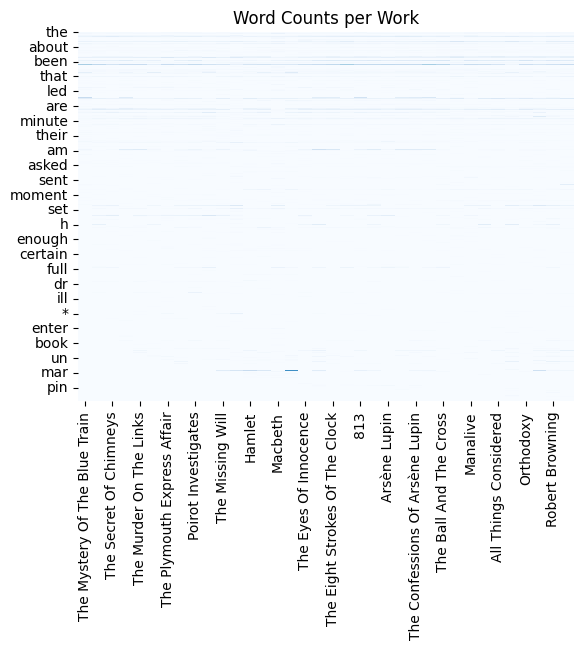

In [7]:

# Get the frequencies of the top words in each work
# For each of the words in the top words, get the frequency in each work
top_words_list = list(top_words.keys())
top_word_freq = {work['title']: {word: freq for word, freq in word_freq_per_work[work['title']].items() if word in top_words_list} for work in corpus}

# Use a different color for each author
df = pd.DataFrame(top_word_freq).fillna(0)
# Get a list of authors
authors = corpus.get_authors()
# Create a color palette
palette = sns.color_palette('hsv', len(authors))
# Create a dictionary mapping authors to colors
colors = {author: palette[i] for i, author in enumerate(authors)}
# Create a list of colors for each work
work_colors = [colors[author] for author in corpus.get_authors()]
# Plot the heatmap with the colors
sns.heatmap(df, cmap='Blues', cbar=False)
plt.title('Word Counts per Work')
plt.show()


In [8]:

# Get the frequencies of the top words in each work
# For each of the words in the top words, get the frequency in each work
top_words_list = list(top_words.keys())
word_freq_per_author = corpus.get_word_freq_per_author()
top_word_freq = {work['author']: {word: freq for word, freq in word_freq_per_author[work['author']].items() if word in top_words_list} for work in corpus}


Starting Maurice Leblanc
Finished Maurice Leblanc
Starting William Shakespeare
Finished William Shakespeare
Starting GK Chesterton
Finished GK Chesterton
Starting Agatha Christie
Finished Agatha Christie


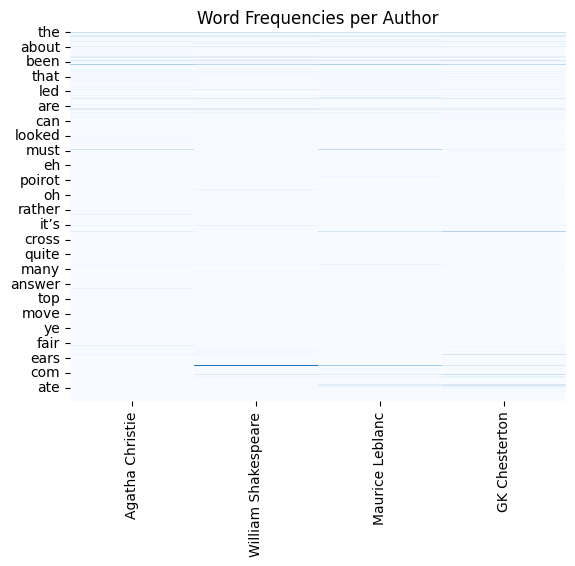

In [9]:

# Use a different color for each author
df = pd.DataFrame(top_word_freq).fillna(0)

sns.heatmap(df, cmap='Blues', cbar=False)
plt.title('Word Frequencies per Author')
plt.show()

In [10]:
# Cluster all the works by their frequencies of all the top words
# Use k-means clustering to group the works by their word frequencies
from sklearn.cluster import KMeans

# Alternative clustering methods:
# - Hierarchical clustering
# - DBSCAN
# - Spectral clustering
# - Affinity propagation

# Use hierarchical clustering to group the works by their word frequencies
from sklearn.cluster import AgglomerativeClustering

avg_sentences_per_work = {work['title']: avg_sentence_length(work['text']) for work in corpus}
avg_word_lengths_per_work = {work['title']: avg_word_length(work['text']) for work in corpus}

def tokens_to_numbers(tokens: List[str], bank: Set[str] | None = None) -> List[int]:
    # For every token, replace it with its index in the bank
    if bank is None:
        bank = set(tokens)
    bank = {token: i for i, token in enumerate(bank)}
    return [bank[token] for token in tokens if token in bank]

all_tokens = tokenize(corpus.collate_texts())

def get_words_in_percentile_range(work: Dict[str, Any], lower: float, upper: float) -> List[str]:
    word_freqs = word_freq_per_work[work['title']]
    # Sort them by frequency
    sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)
    # Get the words in the percentile range
    # Do this by slicing the sorted list
    lower_idx = int(len(sorted_words) * lower)
    upper_idx = int(len(sorted_words) * upper)
    return [word for word, freq in sorted_words[lower_idx:upper_idx]]

def featurize(work: Dict[str, Any], max_tokens: int = 300) -> List[float]:
    # Ensure that the length of each segment is consistent
    segments = [0, 1/5, 2/5, 3/5, 4/5, 1]
    segment_words = [get_words_in_percentile_range(work, segments[i], segments[i+1]) for i in range(len(segments) - 1)]
    
    # Convert words to token numbers and ensure they are consistent by truncating or padding
    segment_nums = []
    for words in segment_words:
        nums = tokens_to_numbers(words, all_tokens)
        if len(nums) > max_tokens:
            segment_nums.append(nums[:max_tokens])  # Truncate if too long
        else:
            segment_nums.append(nums + [0] * (max_tokens - len(nums)))  # Pad if too short
    
    # Return the fixed-length feature vector
    return [avg_word_lengths_per_work[work['title']], avg_sentences_per_work[work['title']]] + [num for segment in segment_nums for num in segment] + [word_freq_per_work[work['title']].get(word, 0) for word in top_words_list]


# Get the frequencies of all the top words in each work
top_words_list = list(top_words.keys())
# word_freq_per_work = corpus.get_word_freq_per_work()
X = np.array([featurize(work) for work in corpus])
# X = np.array([[avg_word_lengths_per_work[work['title']]] + [avg_sentences_per_work[work['title']]] + [word_freq_per_work[work['title']].get(word, 0) for word in top_words_list] for work in corpus])

# Scale the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
X_scaled = X

# Perform k-means clustering
# clustering_algorithm = AgglomerativeClustering(n_clusters=len(corpus.get_authors()), linkage='ward')
# clustering_algorithm = DBSCAN(eps=0.5, min_samples=2)
clustering_algorithm = KMeans(n_clusters=len(corpus.get_authors()))



Iteration 1: Most common clusters - {'Maurice Leblanc': np.int32(0), 'William Shakespeare': np.int32(3), 'GK Chesterton': np.int32(0), 'Agatha Christie': np.int32(0)}
Iteration 2: Most common clusters - {'Maurice Leblanc': np.int32(1), 'William Shakespeare': np.int32(0), 'GK Chesterton': np.int32(1), 'Agatha Christie': np.int32(1)}
Iteration 3: Most common clusters - {'Maurice Leblanc': np.int32(0), 'William Shakespeare': np.int32(2), 'GK Chesterton': np.int32(0), 'Agatha Christie': np.int32(0)}
Iteration 4: Most common clusters - {'Maurice Leblanc': np.int32(0), 'William Shakespeare': np.int32(2), 'GK Chesterton': np.int32(0), 'Agatha Christie': np.int32(1)}
Iteration 5: Most common clusters - {'Maurice Leblanc': np.int32(0), 'William Shakespeare': np.int32(2), 'GK Chesterton': np.int32(0), 'Agatha Christie': np.int32(0)}
Iteration 6: Most common clusters - {'Maurice Leblanc': np.int32(2), 'William Shakespeare': np.int32(3), 'GK Chesterton': np.int32(2), 'Agatha Christie': np.int32(1)

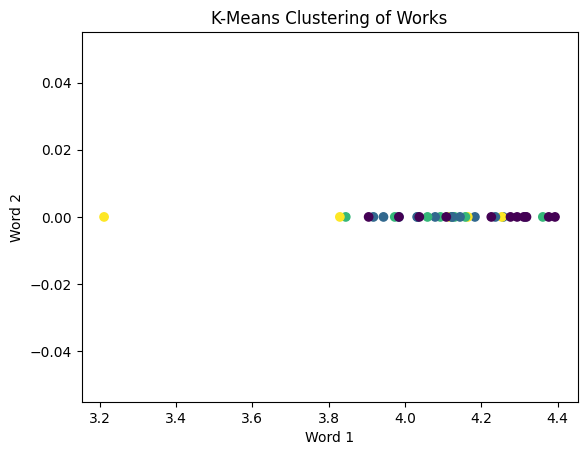

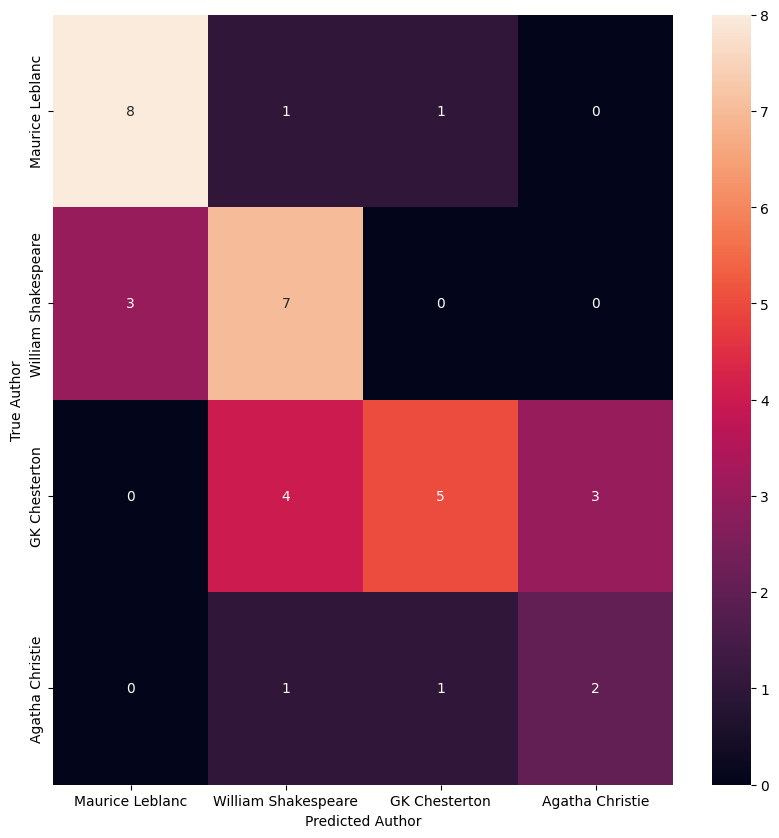

In [11]:
use_max_iterations = False
max_iterations = 10

most_common_clusters = {}
iteration = 0

while len(set(most_common_clusters.values())) < len(corpus.get_authors()):
    iteration += 1

    # Check if maximum iterations should be applied
    if use_max_iterations and iteration > max_iterations:
        print("Reached maximum iterations, breaking loop.")
        break

    # Fit the model
    clustering_algorithm.fit(X_scaled)

    # Get the cluster assignments
    clusters = clustering_algorithm.predict(X_scaled)

    # Print the cluster assignments and true authors
    predicted_assignments = {work['title']: cluster for work, cluster in zip(corpus, clusters)}

    # Now assign the numbers to the authors
    author_assignments = {author: [] for author in corpus.get_authors()}
    for work in corpus:
        author_assignments[work['author']].append(predicted_assignments[work['title']])
        
    # Get the most common cluster for each author
    most_common_clusters = {author: max(set(assignments), key=assignments.count) for author, assignments in author_assignments.items()}

    # Print progress for debugging
    print(f"Iteration {iteration}: Most common clusters - {most_common_clusters}")

print("Final most common clusters:", most_common_clusters)

# Calculate and print accuracy and plot results
correct = 0
confusion_matrix = np.zeros((len(corpus.get_authors()), len(corpus.get_authors())))
for work in corpus:
    true_author = most_common_clusters[work['author']]
    predicted_author = predicted_assignments[work['title']]
    if true_author == predicted_author:
        correct += 1
    confusion_matrix[true_author, predicted_author] += 1

print(f'Accuracy: {correct / len(clusters) * 100:.2f}%')

# Plot the clusters
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Word 1')
plt.ylabel('Word 2')
plt.title('K-Means Clustering of Works')
plt.show()

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=most_common_clusters.keys(), yticklabels=most_common_clusters.keys())
plt.xlabel('Predicted Author')
plt.ylabel('True Author')
plt.show()